## In-class hands-on activity: CNN

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

Note: You do not need a GPU to run the script. (But it will take a bit longer to run without a GPU.)

### Preparation

Save this file, helpers.py, and other image files (e.g., food1.png) in the same directory. 

### Loading the image
這個範例程式使用了helpers.py中的plot()函數 (original from <https://github.com/pytorch/vision/tree/main/gallery/>)。
plot() 能很方便的顯示影像資料。由於資料前處理會對影像做Normalization, 因此直接顯示被Normalize 之後的影像看起來會怪怪的。plot() 能自己判斷影像是否被Normalize過，並在顯示前做相應的處理。然而原始的plot函數會inplace normalize圖片，造成分析上的困擾。這個版本經修正這個問題(clone the variable first)。

除了torch之外，我們也會用到torchvision。這是Pytorch中專門為影像處理設計的一個Library。

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.io import read_file, decode_image
from helpers import plot

torch.manual_seed(2321)
plt.rcParams["savefig.bbox"] = 'tight'

image_bytes = read_file("./food1.png")
img = decode_image(image_bytes)
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 1024, 1024])


上面的資訊對了解一個存放影像的變數非常重要。

### TODO
### 回答下面問題

1. img 這個變數是numpy、torch、或是python內建的變數型別? 單一pixel存放格是為何?
2. 影像pixel存放的格式與x, y, channel的順序為何?



1. img 是 torch 變數型別。單一 pixel 的存放格式為 unit8。
2. 存放順序為 (Channel, y, x)。

### Torchvision Transforms
Torchvision transforms 是準備影像輸入的重要工具。有舊版跟新版(v2)之分。上面import的是新版。

下面是一個簡單的範例 (RandomCrop)。你可以多跑幾次下面這個Cell, 看看右邊的影像有沒有變化，感受一下什麼是RandomCrop。

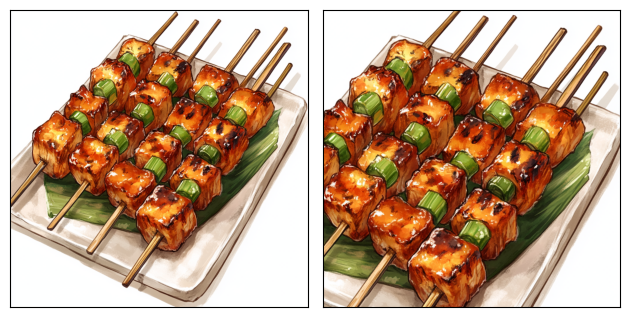

In [2]:
transform = v2.RandomCrop(size=(800, 800))
out = transform(img)
plot([img, out])

### Online Resource

An official tutorial is here: <https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py>

You can find examples of these transforms here <https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html>

下面提供一些常見的影像前處理方法。這些方法通常會在前處理時綜合運用。

#### Padding
各邊補上Pixels, 如沒有指定顏色，預測是黑色。

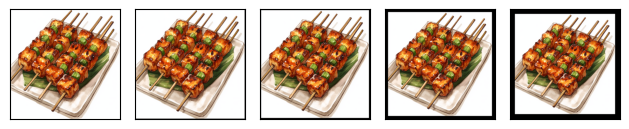

In [3]:
padded_imgs = [v2.Pad(padding=padding)(img) for padding in (3, 10, 30, 50)]
plot([img] + padded_imgs)

#### Center Crop
向中對齊的影像裁切

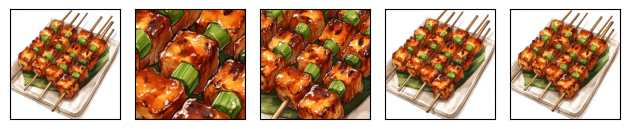

In [4]:
center_crops = [v2.CenterCrop(size=size)(img) for size in (300, 500, 1000, img.size()[1])]
plot([img] + center_crops)

#### Random Perspective
影像隨機視角

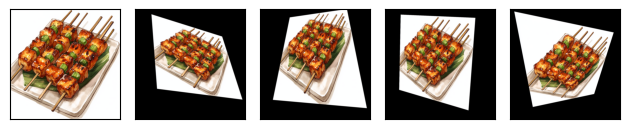

In [5]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(img) for _ in range(4)]
plot([img] + perspective_imgs)

### TODO

* 使用v2.RandomRotation 產生四個影像，與原始影像並列比較。旋轉角度限制在0 - 180度。
* 使用v2.Grayscale 產生一個影像，與原始影像並列比較
* 使用v2.ColorJitter 產生四個影像，與原始影像並列比較。設定brightness=.5, hue=.3。

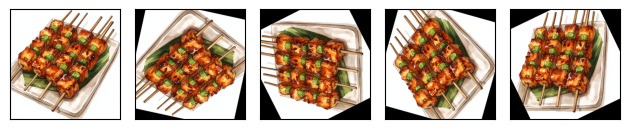

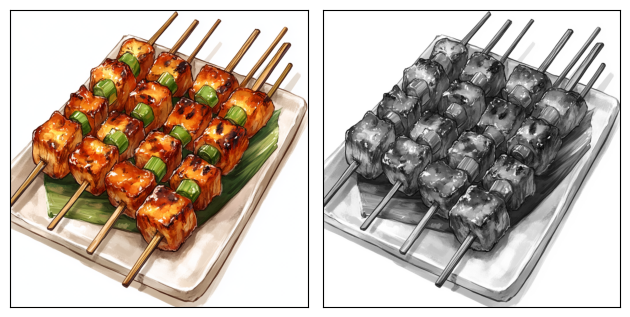

In [2]:
# TODO
rotater = v2.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(img) for _ in range(4)]
plot([img] + rotated_imgs)

grayscaler = v2.Grayscale()
gray_img = grayscaler(img)
plot([img, gray_img], cmap='gray')

### Sample Pipeline

注意: 不同的資料型別在torchvision中會有不同的預設資料區間。如整數型別會是 \[0, 255\]之類的。Float則是\[0, 1\]。

詳細說明參見: https://pytorch.org/vision/main/transforms.html#range-and-dtype

下面是說明的節錄:

Dtype and expected value range The expected range of the values of a tensor image is implicitly defined by the tensor dtype. Tensor images with a float dtype are expected to have values in \[0, 1\]. Tensor images with an integer dtype are expected to have values in \[0, MAX_DTYPE\] where MAX_DTYPE is the largest value that can be represented in that dtype. Typically, images of dtype torch.uint8 are expected to have values in \[0, 255\].

v2.Compose() 可以用來組合並製作出需要的影像前處理與Data Augmentation的流程。

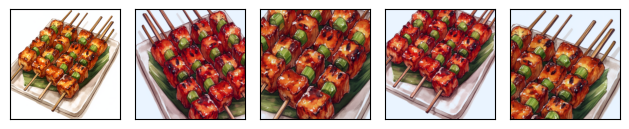

In [9]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=.1, hue=.05),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

outimgs = [transforms(img) for _ in range(4)]
plot([img] + outimgs)

以上是一些影像轉換的範例。下面提供一個小型的CNN分類模型訓練與測試的範例。

### Training a CNN Image Classifier using CIFAR10
比較值得說明的是`v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`這行。這行把一個影像的三個Channel Normalize, 用的是傳入的均數與標準差。**傳說**這組參數是由ImageNet中所有圖片算出來的。

CIFAR10本身內建於torchvision, 作為初步的練習，我們直接使用內建函數下載這個資料集。

In [4]:
# just in case you have not done so
import torch
import torchvision

In [5]:
transform = v2.Compose([
      v2.ToImage(), 
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

batch_size = 6
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


取一個Minibatch試試看

In [12]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [13]:
images.shape

torch.Size([6, 3, 32, 32])

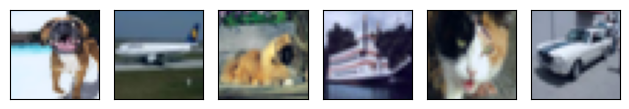

In [14]:
plot(images)

In [15]:
print(" ".join([classes[i] for i in labels]))

dog plane dog ship cat car


### TODO

回答下列問題
1. images 的shape 是什麼? 各維度分別是什麼意思?
   - `torch.Size([6, 3, 32, 32])`
   - Batch Size (6), Channels (3), Height (32), Width (32)



### 定義CNN模型


### TODO:
Define a CNN Model with the following layers:
* Convolution with kernel size = 5, output 6 channels
* ReLU
* Max Pooling with kernel size = 2 and stride = 2
* Convolution with kernel size = 5, output 16 channels
* ReLU
* Max Pooling with kernel size = 2 and stride = 2
* Flatten all features
* a linear layer that output 120 dimensions
* ReLU
* a linear layer that output 84 dimensions
* ReLU
* a linear layer that output 10 dimensions



In [6]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
    
print("Running on device: ", device)
net = torch.nn.Sequential(
# TODO
    torch.nn.Conv2d(3, 6, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(6, 16, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10),

# --- No change below this line ---    
)
# convert everything to float precision. 
net = net.float()
# move the model to device (i.e., cpu or gpu)
net = net.to(device)

Running on device:  cpu


### Summarize Output Dimensions by Layer
You will need to install torchsummary (`!pip install torchsummary`) before running the next cell. If you encounter problems, just skip the next cell (not related to subsequent cells)

In [10]:
# !pip3 install torchsummary

In [11]:
from torchsummary import summary
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
---------------------------------

#### Try to verify the above dimensions by hand!!!

### Model Training
Set number of epochs to 2 below. You should try to extend the setting. 

In [8]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.001
[1,  4000] loss: 1.668
[1,  6000] loss: 1.532
[1,  8000] loss: 1.427
[2,  2000] loss: 1.337
[2,  4000] loss: 1.327
[2,  6000] loss: 1.299
[2,  8000] loss: 1.268
Finished Training


In [10]:
# Save the model
torch.save(net.state_dict(), './cifar_net.pth')

拿一些Test images測試看看

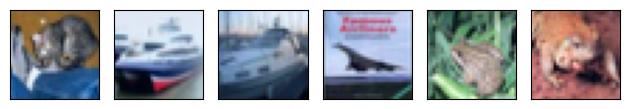

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

plot(images)

In [12]:
# TODO
# pass images through net and print predicted and true labels
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(6)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(6)))

Predicted:  cat   car   car   plane deer  frog 
GroundTruth:  cat   ship  ship  plane frog  frog 


### Sanity Check
<pre>
Predicted: cat ship ship ship deer frog
GroundTruth: cat ship ship plane frog frog    
</pre>

### Test Performance
最後計算預測準確度

In [13]:
# TODO
# Compute and print out test accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


### Sanity Check
<pre>
Accuracy of the network on the 10000 test images: 54 %    
</pre>

### Leveraging Pre-trained Models

Pytorch提供已經訓練好的模型，詳細說明見<https://pytorch.org/vision/main/models.html>

這裡提供一個簡單的使用範例。

ox: 57.3%
airliner: 45.2%
Australian terrier: 3.1%


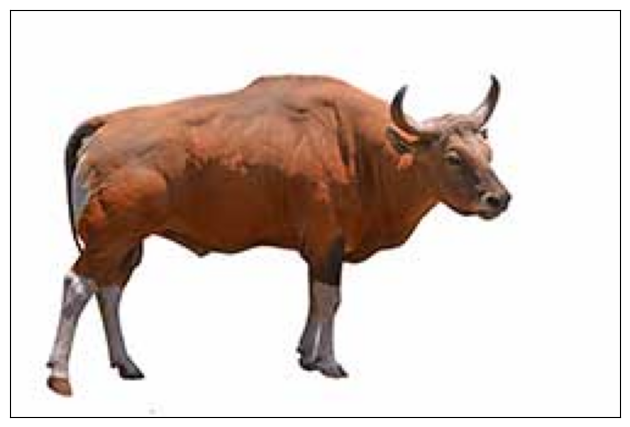

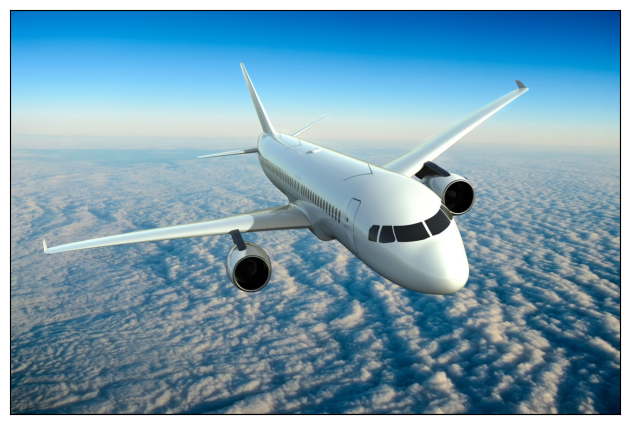

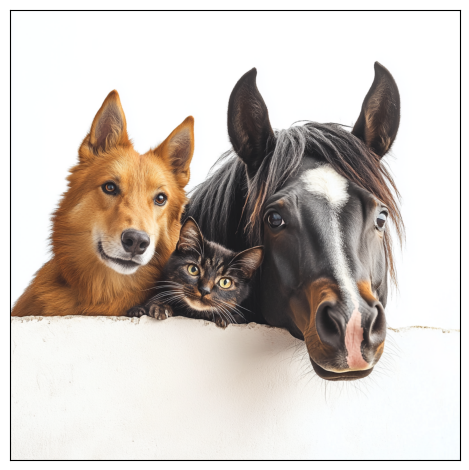

In [29]:
from torchvision.io import decode_image
from torchvision.models import resnet50, ResNet50_Weights

# image_bytes = read_file("horse_dog_cat.png")
# image_bytes = read_file("airplane.jpg")
files = ['ox.jpg', 'airplane.jpg', 'horse_dog_cat.png']

for af in files:
    image_bytes = read_file(af)
    img = decode_image(image_bytes)
    
    # Step 1: Initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.eval()
    
    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()
    
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)
    
    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    plot([img])
    print(f"{category_name}: {100 * score:.1f}%")

# Exercise (No Need to Turn In)

* Apply early stop on CIFAR10 training. What level of performance can you get?
* Adjust the model to improve CIFAR10 classification 
* Find additional images to test the pre-trained models. How good are these pre-trained models?